In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('final_dataset_encoded.csv', low_memory=False)

df = df.drop_duplicates(subset='idOSYM', keep='first')

# Split data by academic year
df_2021 = df[df['academicYear'] == 2021]
df_2022 = df[df['academicYear'] == 2022]

# Find common ids between the two years
common_ids = set(df_2021['idOSYM']).intersection(set(df_2022['idOSYM']))

# Convert to a list or back to a Series if needed
common_ids = list(common_ids)  # Or pd.Series(common_ids)
print(len(df_2022))
print(len(common_ids))


618
0


## Lag Features

In [89]:
df['lag_baseRanking'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['baseRanking'].shift(1)
df['lag_baseRanking'] = df['lag_baseRanking'].fillna(df['baseRanking'])
df['lag_quota'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['quota'].shift(1)
df['lag_quota'] = df['lag_quota'].fillna(df['quota'])
df['lag_revenue'] = df.groupby(['universityName_encoded', 'departmentName_encoded', 'scholarshipRate'])['revenue'].shift(1)
df['lag_revenue'] = df['lag_revenue'].fillna(df['revenue'])

print(df.head())


   academicYear     idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
0          2021  106510077              0.0     70             70         0.0   
1          2021  106510077              0.0     70             70         0.0   
2          2022  106510077              0.0     75             75         0.0   
3          2022  106510077              0.0     75             75         0.0   
4          2023  106510077              0.0     75             75         0.0   

   universityLocation  universityRegion  profCount  assoCount  ...  \
0                  41                 6        1.0        1.0  ...   
1                  41                 6        1.0        1.0  ...   
2                  41                 6        1.0        1.0  ...   
3                  41                 6        1.0        1.0  ...   
4                  41                 6        0.0        1.0  ...   

   language_Çince  language_İngilizce  language_İspanyolca  \
0               0             

## Year-over-Year Change Features

In [90]:
df['yoy_baseRanking'] = df['baseRanking'] - df['lag_baseRanking']
df['yoy_quota'] = df['quota'] - df['lag_quota']
df['yoy_revenue'] = df['revenue'] - df['lag_revenue']

print(df.head())


   academicYear     idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
0          2021  106510077              0.0     70             70         0.0   
1          2021  106510077              0.0     70             70         0.0   
2          2022  106510077              0.0     75             75         0.0   
3          2022  106510077              0.0     75             75         0.0   
4          2023  106510077              0.0     75             75         0.0   

   universityLocation  universityRegion  profCount  assoCount  ...  \
0                  41                 6        1.0        1.0  ...   
1                  41                 6        1.0        1.0  ...   
2                  41                 6        1.0        1.0  ...   
3                  41                 6        1.0        1.0  ...   
4                  41                 6        0.0        1.0  ...   

   language_İtalyanca  universityName_encoded  departmentName_encoded  \
0                  

## Economic Features and Trends

In [91]:
# Lagging economic features
df['lag_inflation'] = df.groupby('academicYear')['inflation_by_year'].shift(1)
df['lag_growth_rate'] = df.groupby('academicYear')['growth_by_year'].shift(1)
df['lag_base_salary'] = df.groupby('academicYear')['base_salary_by_year'].shift(1)

df['lag_inflation'] = df['lag_inflation'].fillna(df['inflation_by_year'])
df['lag_growth_rate'] = df['lag_growth_rate'].fillna(df['growth_by_year'])
df['lag_base_salary'] = df['lag_base_salary'].fillna(df['base_salary_by_year'])

# Inflation-adjusted features
df['real_tuition_fee'] = df['tuitionFee'] / (1 + df['inflation_by_year'] / 100)
df['real_base_salary'] = df['base_salary_by_year'] / (1 + df['inflation_by_year'] / 100)

# Ratios and trends
df['tuition_to_salary_ratio'] = df['tuitionFee'] / df['base_salary_by_year']
df['growth_to_inflation_ratio'] = df['growth_by_year'] / df['inflation_by_year']
df['inflation_trend'] = df['inflation_by_year'] - df['lag_inflation']

print(df.head())
print(df.isnull().sum())

   academicYear     idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
0          2021  106510077              0.0     70             70         0.0   
1          2021  106510077              0.0     70             70         0.0   
2          2022  106510077              0.0     75             75         0.0   
3          2022  106510077              0.0     75             75         0.0   
4          2023  106510077              0.0     75             75         0.0   

   universityLocation  universityRegion  profCount  assoCount  ...  yoy_quota  \
0                  41                 6        1.0        1.0  ...        0.0   
1                  41                 6        1.0        1.0  ...        0.0   
2                  41                 6        1.0        1.0  ...        5.0   
3                  41                 6        1.0        1.0  ...        0.0   
4                  41                 6        0.0        1.0  ...        0.0   

   yoy_revenue  lag_inflat

## Baseline Model

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

binary_features = [
    'universityType_devlet', 'universityType_vakıf', 'programType_DİL', 'programType_EA', 
    'programType_SAY', 'programType_SÖZ', 'language_Almanca', 'language_Arapça', 'language_Bulgarca', 'language_English', 
    'language_Ermenice', 'language_Fransızca', 'language_Korece', 'language_Lehçe', 'language_Rusça', 'language_Turkish', 
    'language_Türkçe', 'language_Çince', 'language_İngilizce', 'language_İspanyolca', 'language_İtalyanca', 
    'academicYear', 'baseRanking'
]
print(df[binary_features].describe().round(3))
print(len(binary_features))


       universityType_devlet  universityType_vakıf  programType_DİL  \
count              54496.000             54496.000        54496.000   
mean                   0.607                 0.393            0.051   
std                    0.488                 0.488            0.221   
min                    0.000                 0.000            0.000   
25%                    0.000                 0.000            0.000   
50%                    1.000                 0.000            0.000   
75%                    1.000                 1.000            0.000   
max                    1.000                 1.000            1.000   

       programType_EA  programType_SAY  programType_SÖZ  language_Almanca  \
count       54496.000        54496.000        54496.000         54496.000   
mean            0.319            0.457            0.172             0.004   
std             0.466            0.498            0.377             0.066   
min             0.000            0.000            0.

In [96]:

encoded_features = ['universityName_encoded', 'departmentName_encoded', 'facultyName_encoded']
print(df[encoded_features].describe().round(3))

numeric_features = []
for feature in df.columns:
    if feature not in binary_features:
        numeric_features.append(feature)
        
print(len(numeric_features))

       universityName_encoded  departmentName_encoded  facultyName_encoded
count               54496.000               54496.000            54496.000
mean                  266.226                 266.226              266.226
std                    83.661                 154.499              124.930
min                    40.175                   0.000                0.000
25%                   202.341                 142.345              159.344
50%                   269.750                 269.177              295.544
75%                   333.143                 396.067              325.321
max                   525.039                 969.993              767.799
58


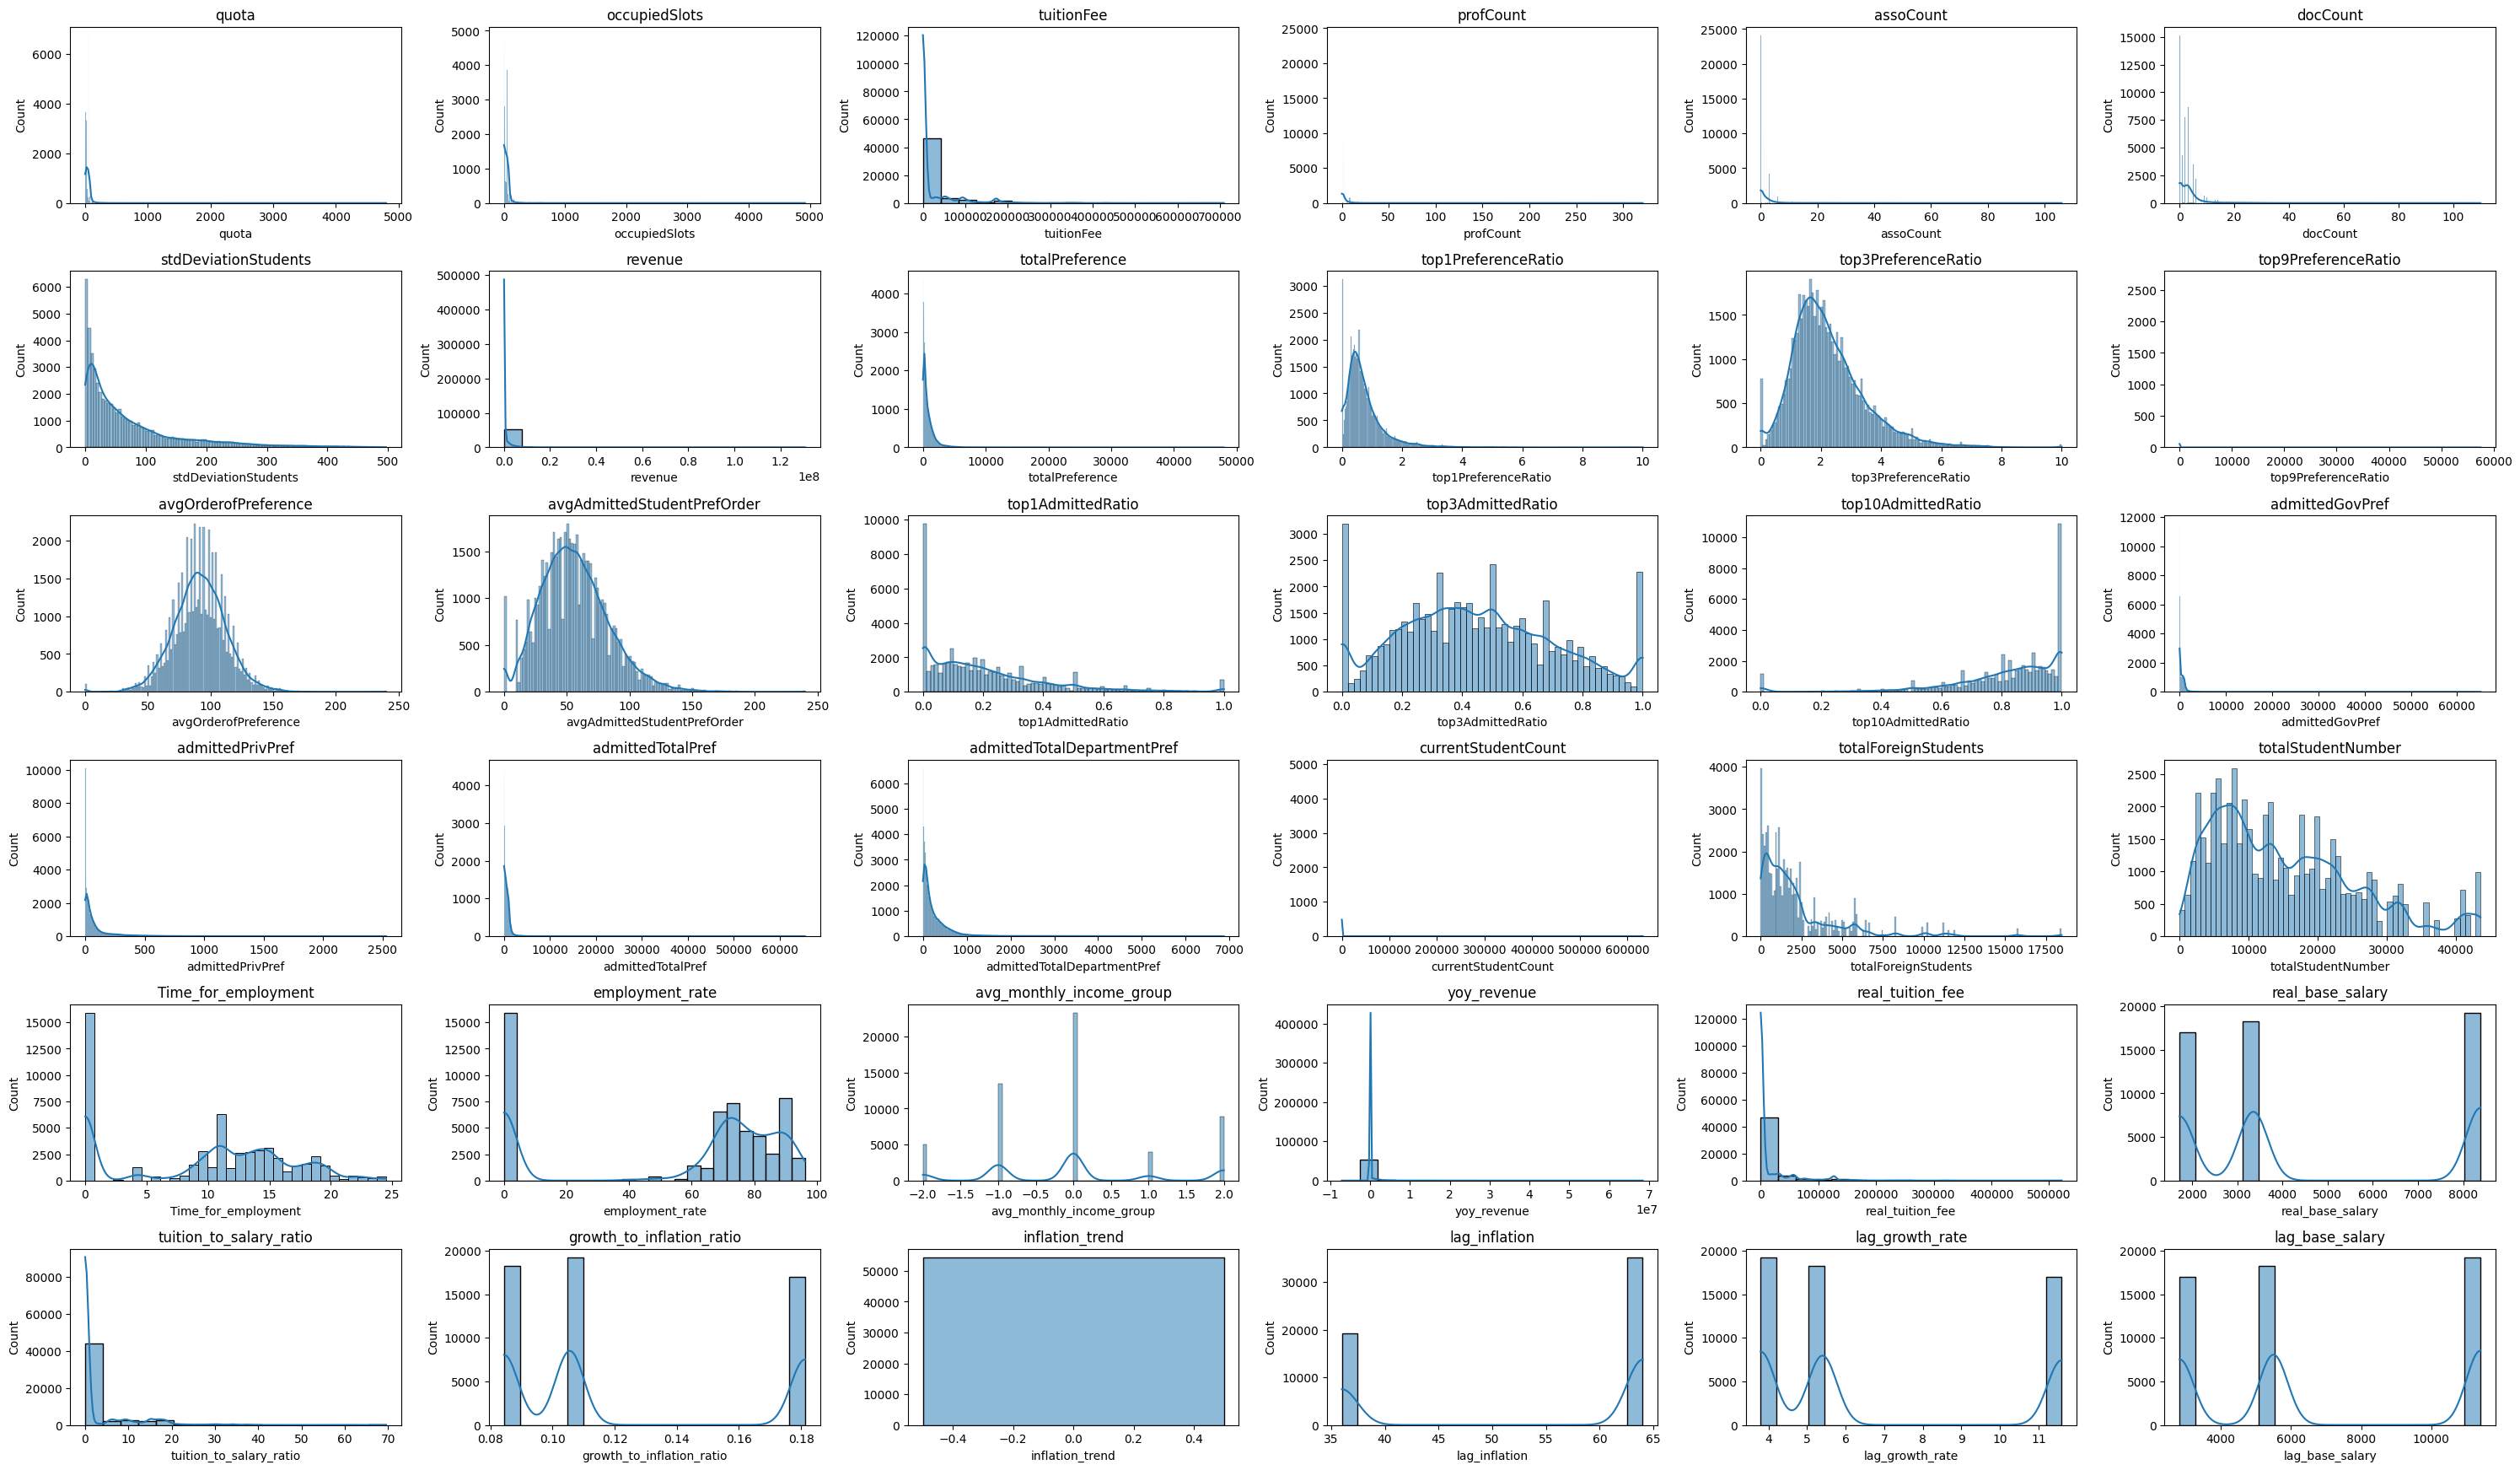

In [ ]:
# Plot histograms for continuous features
plt.figure(figsize=(30, 20))
for i, feature in enumerate(numeric_features):
    plt.subplot(7, 6, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(feature)
plt.tight_layout()
plt.show()



In [97]:
# Calculate skewness of each continuous feature
skew_values = df[numeric_features].skew()

# Filter features with skewness greater than 1 or less than -1 (this is an arbitrary threshold)
skew_features = skew_values[abs(skew_values) > 1].index.tolist()

# Display skew features
print("Skewed Features:", skew_features)
print(len(skew_features))

continuous_features = [col for col in numeric_features if col not in skew_features]

print("Continous Features:", continuous_features)
print(len(continuous_features))

Skewed Features: ['scholarshipRate', 'quota', 'occupiedSlots', 'tuitionFee', 'profCount', 'assoCount', 'docCount', 'topRanking', 'stdDeviationStudents', 'revenue', 'totalPreference', 'top1PreferenceRatio', 'top3PreferenceRatio', 'top9PreferenceRatio', 'top1AdmittedRatio', 'top10AdmittedRatio', 'admittedGovPref', 'admittedPrivPref', 'admittedTotalPref', 'admittedTotalDepartmentPref', 'currentStudentCount', 'totalForeignStudents', 'lag_quota', 'lag_revenue', 'yoy_baseRanking', 'yoy_quota', 'yoy_revenue', 'real_tuition_fee', 'tuition_to_salary_ratio']
29
Continous Features: ['idOSYM', 'universityLocation', 'universityRegion', 'outOfCityStudentRate', 'sameRegionStudentRate', 'avgOrderofPreference', 'avgAdmittedStudentPrefOrder', 'top3AdmittedRatio', 'totalStudentNumber', 'Urap_Rank', 'Urap_Score', 'Time_for_employment', 'employment_rate', 'avg_monthly_income_group', 'base_salary_by_year', 'inflation_by_year', 'growth_by_year', 'avgAdmissionRanking', 'baseAdmissionRanking', 'universityName_

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# Define transformations
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()
encoder = OneHotEncoder(handle_unknown='ignore')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features (standard scaling)
        ('num', scaler_standard, continuous_features),
        
        # Skewed features (log transformation + standard scaling)
        ('skewed', Pipeline(steps=[
            ('log', FunctionTransformer(np.log1p, validate=True)),
            ('scaler', scaler_standard)
        ]), skew_features),
    ]
)

# Add a small constant to skewed features to avoid -inf values
df[skew_features] = df[skew_features] + 0.1

processed_data = preprocessor.fit_transform(df)

processed_df = pd.DataFrame(processed_data, columns=continuous_features + skew_features)

print(processed_df[numeric_features].describe().round(3))



          idOSYM  scholarshipRate      quota  occupiedSlots  tuitionFee  \
count  54496.000        54496.000  54496.000      54496.000   54496.000   
mean      -0.000            0.000     -0.000          0.000       0.000   
std        1.000            1.000      1.000          1.000       1.000   
min       -0.921           -0.724     -2.718         -2.729      -0.500   
25%       -0.824           -0.724     -0.655         -0.726      -0.500   
50%       -0.728           -0.724      0.294          0.271      -0.500   
75%        1.209            1.183      0.696          0.780      -0.500   
max        1.368            1.522      5.116          4.555       2.496   

       universityLocation  universityRegion  profCount  assoCount   docCount  \
count           54496.000         54496.000  54496.000  54496.000  54496.000   
mean               -0.000             0.000     -0.000     -0.000     -0.000   
std                 1.000             1.000      1.000      1.000      1.000   
min 

/Users/omeryildiz/Documents/GitHub/WebScraping-Dataset-/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_function_transformer.py:379: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


## Feature Selection 

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.concat([df[binary_features], processed_df], axis=1)
print(df.head())

target = 'baseRanking'  # Target variable

df_2021 = df[df['academicYear'] == 2021]
df_2022 = df[df['academicYear'] == 2022]

# Ensure the same number of samples for X and y


X = df_2021.loc[common_indices].drop(columns=['baseRanking', 'academicYear'])
y = df_2022.loc[common_indices, 'baseRanking']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

# Print top 10 most important features
print(importance_df.head(30))





   universityType_devlet  universityType_vakıf  programType_DİL  \
0                      1                     0                0   
1                      1                     0                0   
2                      1                     0                0   
3                      1                     0                0   
4                      1                     0                0   

   programType_EA  programType_SAY  programType_SÖZ  language_Almanca  \
0               0                1                0                 0   
1               0                1                0                 0   
2               0                1                0                 0   
3               0                1                0                 0   
4               0                1                0                 0   

   language_Arapça  language_Bulgarca  language_English  ...  \
0                0                  0                 0  ...   
1                0            